# Plot GFS fields on top of GOES imagery.

The following line will produce plots within the notebook instead of as separate windows. If you want a separate window, delete the cell or comment the line within the cell with a # sign at the beginning of it.

In [1]:
#%matplotlib inline

In [2]:
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime
from netCDF4 import Dataset
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy
import numpy as np
import requests
import urllib3
import warnings
import xarray as xr

### Provide the map domain bounds (latitude and longitude), the date of interest, and the ABI band number in the below cell.

In [3]:
minlat = 26.                # CONUS min: 26.
maxlat = 49.                # CONUS max: 49.
minlon = -125.              # CONUS min: -125.
maxlon = -70.               # CONUS max: -70.
date_string = '2024030112'  # Example string -- '2020040100' equates to 00 UTC 1 April 2020
channel = 9                 # ABI band number (9 = mid-level water vapor, 13 = clean longwave infrared)
geoheight_level = 500       # pressure level (in hPa) for which to show geopotential height
wind_level = 250            # pressure level (in hPa) for which to show winds
sat_bucket = 'noaa-goes16'  # change number to desired satellite as needed (16, 17, 18, 19)

dt = datetime.strptime(date_string, '%Y%m%d%H')
PNGname = 'GFS-wind-heights_ABIband%02d_%s' % (channel,dt.strftime('%Y%m%d%H.png'))

### Custom functions are provided in the below cell.

<em>(You should NOT need to make any changes to these functions. Pay attention to the doc strings for expected arrays and units.)</em>

'<span style="font-family:monospace;">get_s3_keys()</span>' identifies ABI file names on Amazon Web Services.<br />
'<span style="font-family:monospace;">pullABIdata()</span>' obtains ABI data from Amazon Web Services.<br />
'<span style="font-family:monospace;">satcolor()</span>' returns custom colormaps + value ranges + geography line colors for Band 2, Band 8-10, and Band 13 imagery.<br />
'<span style="font-family:monospace;">airmassRGB()</span>' returns an array and tuple for plotting airmass RGB imagery.<br />
'<span style="font-family:monospace;">ntmicroRGB()</span>' returns an array and tuple for plotting nighttime microphysics RGB imagery.<br />
'<span style="font-family:monospace;">abilatlon()</span>' computes 2-D latitude and longitude arrays from native GOES ABI coordinates (for map plotting).
'<span style="font-family:monospace;">addgridlines()</span>' adds nice-looking latitude and longitude lines + labels to map.

In [4]:
def get_s3_keys(band, date, product='ABI-L2-CMIPC', bucket='noaa-goes16', sector=0, abimode=0, return_mode=False):
    """
    Identify ABI file(s) for desired date from Amazon Web Services.
    product = 'ABI-L2-CMIPC'  # defaults to CONUS imagery
    bucket = 'noaa-goes16'    # defaults to GOES-16
    """
    format_date = date.strftime('/%Y/%j/%H')
    prefix = product + format_date + '/OR_'+ product + '-M3C' + str(band).zfill(2)
    keys = []  # empty list to store the paths ("keys") for the desired files
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    kwargs = {'Bucket': bucket}
    ## Loop through possible modes IF mode not already identified
    if abimode == 0:
        for mode in range(1,7):  # try the possible modes (1-6) rather than assuming any one mode is active
            if sector > 0:
                prefix2 = '%s%d-M%dC%02d' % (prefix.split('-M')[0], sector, mode, band)
            else:
                prefix2 = '%s-M%dC%02d' % (prefix.split('-M')[0], mode, band)
            kwargs['Prefix'] = prefix2
            resp = s3.list_objects_v2(**kwargs)
            try:
                contents = resp['Contents']
                for i in range(len(contents)):  # loop over all entries in 'Contents'
                    key = contents[i]['Key']
                    keys.append(key)
            except KeyError:  # skip this mode if KeyError occurs (meaning there is no entry named 'Contents')
                continue
    else:
        mode = abimode
        if sector > 0:
            if prefix.find('ACHA') > -1:
                prefix2 = '%s%d-M%d' % (prefix.split('-M')[0], sector, mode)
            else:
                prefix2 = '%s%d-M%dC%02d' % (prefix.split('-M')[0], sector, mode, band)
        else:
            if prefix.find('ACHA') > -1:
                prefix2 = '%s-M%d' % (prefix.split('-M')[0], mode)
            else:
                prefix2 = '%s-M%dC%02d' % (prefix.split('-M')[0], mode, band)
            kwargs['Prefix'] = prefix2
            resp = s3.list_objects_v2(**kwargs)
            contents = resp['Contents']
            for i in range(len(contents)):  # loop over all entries in 'Contents'
                key = contents[i]['Key']
                keys.append(key)
    ## Return list of keys OR 'bad' if no files are found
    if len(keys) == 0:
        if return_mode is False:
            return ['bad']
        else:
            return ['bad'], 0  # if there are no files, we won't have a correct ABI mode value!
    else:
        if return_mode is False:
            return keys
        else:
            return keys, mode

def pullABIdata(band, date, bucket='noaa-goes16', extra=False):
    """
    Obtain ABI data for desired band and date from Amazon Web Services.
    bucket = 'noaa-goes16'      # defaults to GOES-16
    """
    keys = get_s3_keys(band, date)
    times = [datetime.strptime(k.split('_s')[1][0:11],'%Y%j%H%M') for k in keys]
    for t in range(len(times)):
        if (times[t]-date).seconds < 300:
            key = keys[t]
            break
    resp = requests.get('https://' + bucket + '.s3.amazonaws.com/' + key)
    FileName = key.split('/')[-1].split('.')[0]  # strip everything from 'key' except the filename
    nc = Dataset(FileName, memory=resp.content)  # remotely access ABI file without downloading it!
    store = xr.backends.NetCDF4DataStore(nc)
    DS = xr.open_dataset(store)  # open the remote netCDF file as a dataset using xarray
    if extra is True:
        dat = DS.metpy.parse_cf('CMI')
        geos = dat.metpy.cartopy_crs
        x = dat.x
        y = dat.y
        return DS['CMI'].values, x, y, geos
    else:
        return DS['CMI'].values

def satcolor(typ):
    """
    Return a colormap and value intervals depending on desired GOES image type.
        - Possible types: VIS, WV, LWIR
    For IR and WV bands, expects values in degrees Celsius.
    """
    prefix = 'https://kouya.has.arizona.edu/files/'
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    if typ.upper() == 'VIS':
        ## For red visible channel (Band 2) but could be used for Band 1 and Band 3
        URL = prefix + 'squareRootVIS.txt'
        mrr = requests.get(URL, verify=False).text.split('\n')
        colors = np.array([line.split() for line in mrr[0:len(mrr)-1]], dtype=np.float32)
        cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)  # grayscale colormap
        levs = np.linspace(0.,1.,colors.shape[0],endpoint=True)
        clevs = np.linspace(0.,1.,11,endpoint=True)
        statecolor = 'yellow'
    elif typ.upper() == 'WV':
        ## For water vapor channels (Bands 8-10)
        ## Adapted from from SIFT's WV_Dry_Yellow.cmap file
        URL = prefix + 'dryWVyellow.txt'
        mrr = requests.get(URL, verify=False).text.split('\n')
        colors = np.array([line.split() for line in mrr[0:len(mrr)-1]], dtype=np.float32)
        cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors)
        levs = np.arange(-80.,11.,1.)
        clevs = np.arange(-80.,11.,10.)
        statecolor = 'k'
    elif typ.upper() == 'LWIR':
        ## For longwave infrared channels (e.g., Band 13)
        ## Partially adapted from from SIFT's IR_Color_Clouds_Summer.cmap file
        URL = prefix + 'rainbowIRsummer.txt'
        mrr = requests.get(URL, verify=False).text.split('\n')
        colors = np.array([line.split() for line in mrr[0:len(mrr)-1]], dtype=np.float32)
        cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors)
        ccols = np.concatenate((np.linspace(0.09,0.8983,71),np.linspace(0.905,1.,61)))
        cmap2 = cmap(ccols)
        cmap = mcolors.LinearSegmentedColormap.from_list('cmap', cmap2)
        levs = np.arange(-90.,41.,1.)
        clevs = np.arange(-90.,40.1,10.)
        statecolor = 'k'
    return cmap, levs, clevs, statecolor

def rgbcolor(red, green, blue):
    """
    Given inputs of red, green, and blue components, return combined (RGB) image.
    """
    rgb = np.dstack((red,green,blue))
    rgb = rgb[:,:-1,:]
    colorTuple = rgb.reshape((rgb.shape[0]*rgb.shape[1]),3)
    return rgb, colorTuple

def airmassRGB(c08, c10, c12, c13):
    """
    Given ABI Band 8, Band 10, Band 12, and Band 13 arrays, return airmass RGB.
    Expects input values in Kelvin or degrees Celsius.
    Follows https://www.star.nesdis.noaa.gov/goes/documents/QuickGuide_GOESR_AirMassRGB_final.pdf
    """
    #### Red band (**difference**)
    red = c08 - c10
    red = (red+26.2)/(26.2+0.6) # range: -26.2 to 0.6 C
    red[np.isnan(red)] = 0.
    red[red<0.] = 0.
    red[red>1.] = 1.
    #### Green band (**difference**)
    green = c12 - c13
    green = (green+43.2)/(43.2+6.7) # range: -43.2 to 6.7 C
    green[np.isnan(green)] = 0.
    green[green<0.] = 0.
    green[green>1.] = 1.
    #### Blue band
    blue = c08.copy()
    if np.nanmin(c08) > 0.:
        ## Handles values provided in Kelvin rather than degC.
        blue = c08 - 273.15
    blue = -1.*blue                   # INVERTED
    blue = (blue-29.25)/(64.65-29.25) # range: -29.25 to -64.65 C
    blue[np.isnan(blue)] = 0.
    blue[blue<0.] = 0.
    blue[blue>1.] = 1.
    RGBarray, RGBcolorTuple = rgbcolor(red, green, blue)
    return RGBarray, RGBcolorTuple

def ntmicroRGB(c07, c13, c15):
    """
    Given ABI Band 7, Band 13, and Band 15 arrays, return nighttime microphysics RGB.
    Expects input values in Kelvin or degrees Celsius.
    Follows https://www.star.nesdis.noaa.gov/goes/documents/QuickGuide_GOESR_NtMicroRGB_final.pdf
    """
    #### Red band (**difference**)
    red = c15 - c13
    red = (red+6.7)/(6.7+2.6) # range: -6.7 to 2.6 C
    red[np.isnan(red)] = 0.
    red[red<0.] = 0.
    red[red>1.] = 1.
    #### Green band (**difference**)
    green = c13 - c07
    green = (green+3.1)/(3.1+5.2) # range: -3.1 to 5.2 C
    green[np.isnan(green)] = 0.
    green[green<0.] = 0.
    green[green>1.] = 1.
    #### Blue band
    blue = c13.copy()
    if np.nanmin(c13) > 0.:
        ## Handles values provided in Kelvin rather than degC.
        blue = c13 - 273.15
    blue = (blue+29.6)/(29.6+19.5) # range: -29.6 to 19.5 C
    blue[np.isnan(blue)] = 0.
    blue[blue<0.] = 0.
    blue[blue>1.] = 1.
    RGBarray, RGBcolorTuple = rgbcolor(red, green, blue)
    return RGBarray, RGBcolorTuple

def abilatlon(ds):
    """
    Given an xarray Dataset of ABI data, compute 2-D latitude and longitude grids from native GOES ABI coordinates (x, y).
    """
    H0, r_eq, r_pol, lon0 = [None] * 4
    x = np.array(ds['x'][:])
    y = np.array(ds['y'][:])
    info = str(ds['goes_imager_projection']).split('\n')
    for line in info:
        if line.find('perspective_point_height') > -1:
            H0 = float(line.strip().split()[1])
        if line.find('semi_major_axis') > -1:
            r_eq = float(line.strip().split()[1])
        if line.find('semi_minor_axis') > -1:
            r_pol = float(line.strip().split()[1])
        if line.find('longitude_of_projection_origin') > -1:
            lon0 = float(line.strip().split()[1])
    H = H0 + r_eq
    xgrid, ygrid = np.meshgrid(x, y)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # avoids error message for non-earth locations in full disk images
        a = np.sin(xgrid)*np.sin(xgrid) + np.cos(xgrid)*np.cos(xgrid)*(np.cos(ygrid)*np.cos(ygrid) + ((r_eq*r_eq)/
                                                                       (r_pol*r_pol))*np.sin(ygrid)*np.sin(ygrid))
        b = -2.*H*np.cos(xgrid)*np.cos(ygrid)
        c = H*H - r_eq*r_eq
        r_s = (-1.*b - np.sqrt(b*b - 4.*a*c))/(2.*a)
        s_x = r_s*np.cos(xgrid)*np.cos(ygrid)
        s_y = -1.*r_s*np.sin(xgrid)
        s_z = r_s*np.cos(xgrid)*np.sin(ygrid)
        abilat = 180.*np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*s_z/np.sqrt((H-s_x)**2. + s_y**2.))/np.pi
        abilon = lon0 - 180.*np.arctan(s_y/(H-s_x))/np.pi
    abilat[np.isnan(abilat)] = -90.
    abilon[np.isnan(abilon)] = -90.
    return abilat, abilon

def addgridlines(axes):
    """
    axes is the axis object ('ax')
    """
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5)
    gl.xlocator = mticker.FixedLocator(np.arange(-180.,0.,5.))
    gl.ylocator = mticker.FixedLocator(np.arange(0.,61.,5.))
    gl2 = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., alpha=0.)
    gl2.rotate_labels = False  # disable rotated lat/lon labels
    gl2.top_labels = False     # turn off labels along top x-axis
    gl2.right_labels = False   # turn off labels along right y-axis
    gl2.xlocator = mticker.FixedLocator(np.arange(-180.,0.,5.))
    gl2.ylocator = mticker.FixedLocator(np.arange(0.,61.,5.))
    gl2.xlabel_style = {'size': 12}  # change font size for longitude labels
    gl2.ylabel_style = {'size': 12}  # change font size for latitude labels

def addcolorbar(figobject, axes, contourdata, ticks, cbar_title):
    """
    figobject is the figure object ('fig')
    axes is the axis object ('ax')
    contourdata is the result from calling contourf()
    ticks are the values to be labeled on the colorbar
    cbar_title is the label to add to the colorbar
    """
    axes_bbox = axes.get_position()
    left = axes_bbox.x0
    bottom = axes_bbox.y1 + 0.01
    width = 0.3
    height = 0.015
    cax = figobject.add_axes([left, bottom, width, height])
    cbar = plt.colorbar(contourdata, cax=cax, ticks=ticks, orientation='horizontal', extendfrac='auto')
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.xaxis.set_ticks_position('top')
    if cbar_title != '':
        cbar.set_label(cbar_title, size=11)

### The remainder of the script pulls GOES ABI + GFS data for the desired date and time. No need to modify below code unless you're modifying which fields are being displayed, the contour level values, etc.

<strong>NOTE:</strong> This script defaults to GOES-East (GOES-16) imagery. Update the bucket to the corresponding number for other satellites (GOES-17, GOES-18, GOES-19).

In [5]:
#### Confirm that provided longitudes are negative if in Western Hemisphere (instead of 0-360 format).
if minlon > 180.:
    minlon -= 360.
if maxlon > 180.:
    maxlon -= 360.

#### Map settings.
pc = ccrs.PlateCarree()
map_scale = '10m'
borders = cfeature.BORDERS.with_scale(map_scale)
states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale=map_scale, 
                                      facecolor='none')
lakes = cfeature.LAKES.with_scale(map_scale)
coastline = cfeature.COASTLINE.with_scale(map_scale)
cenlon = (maxlon-minlon)/2. + minlon
cenlat = (maxlat-minlat)/2. + minlat
merc = ccrs.Mercator(central_longitude=cenlon, latitude_true_scale=cenlat)
bandtype = {2: 'VIS', 8: 'WV', 9: 'WV', 10: 'WV', 13: 'LWIR'}
colormap, color_levels, tick_levels, geog_color = satcolor(bandtype[channel])
v0, v1 = [color_levels.min(), color_levels.max()]
geos = None
gfsDS = None
gfs_pfx = 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds083.3/'

In [6]:
#### Obtain ABI data.
if geos is None:
    abi, xx, yy, geos = pullABIdata(channel, dt, bucket=sat_bucket, extra=True)
else:
    abi = pullABIdata(channel, dt, bucket=sat_bucket)

if np.nanmin(abi) > 0. and channel >= 7:
    abi -= 273.15  # convert Kelvin to degC for IR channels (ABI bands 7-16)

In [7]:
#### Create xarray Dataset of GFS data from RDA server.
if gfsDS is None:
    URL = gfs_pfx + dt.strftime('%Y/%Y%m/gdas1.fnl0p25.%Y%m%d%H.f00.grib2')
    gfsDS = xr.open_dataset(URL)

In [8]:
#### Obtain 200-hPa U and V wind + 500-hPa geopotential height from xarray Dataset.
FF = {'u': 'u-component_of_wind_isobaric', 'v': 'v-component_of_wind_isobaric', 'ght': 'Geopotential_height_isobaric'}
PP = {}
for key in list(FF.keys()):
    ## Address the fact that GFS uses multiple names for its pressure coordinate (isobaric, isobaric3, etc.)
    coords = list(gfsDS[FF[key]].coords)
    for c in coords:
        if c.find('isobaric') > -1:
            PP[key] = c
Xslice = slice(minlon+360., maxlon+360.)
Yslice = slice(maxlat, minlat)  # GFS data starts at 90N
keyword_args = {'time': np.datetime64(dt), PP['u']: wind_level*100, 'lat': Yslice, 'lon': Xslice}
u = {wind_level: gfsDS[FF['u']].sel(**keyword_args)}
keyword_args = {'time': np.datetime64(dt), PP['v']: wind_level*100, 'lat': Yslice, 'lon': Xslice}
v = {wind_level: gfsDS[FF['v']].sel(**keyword_args)}
keyword_args = {'time': np.datetime64(dt), PP['ght']: geoheight_level*100, 'lat': Yslice, 'lon': Xslice}
ght = {geoheight_level: gfsDS[FF['ght']].sel(**keyword_args)}

#### Create 2-D latitude and longitude grids for plotting
lon = ght[geoheight_level].lon.values - 360.
lat = ght[geoheight_level].lat.values
lon2d, lat2d = np.meshgrid(lon, lat)

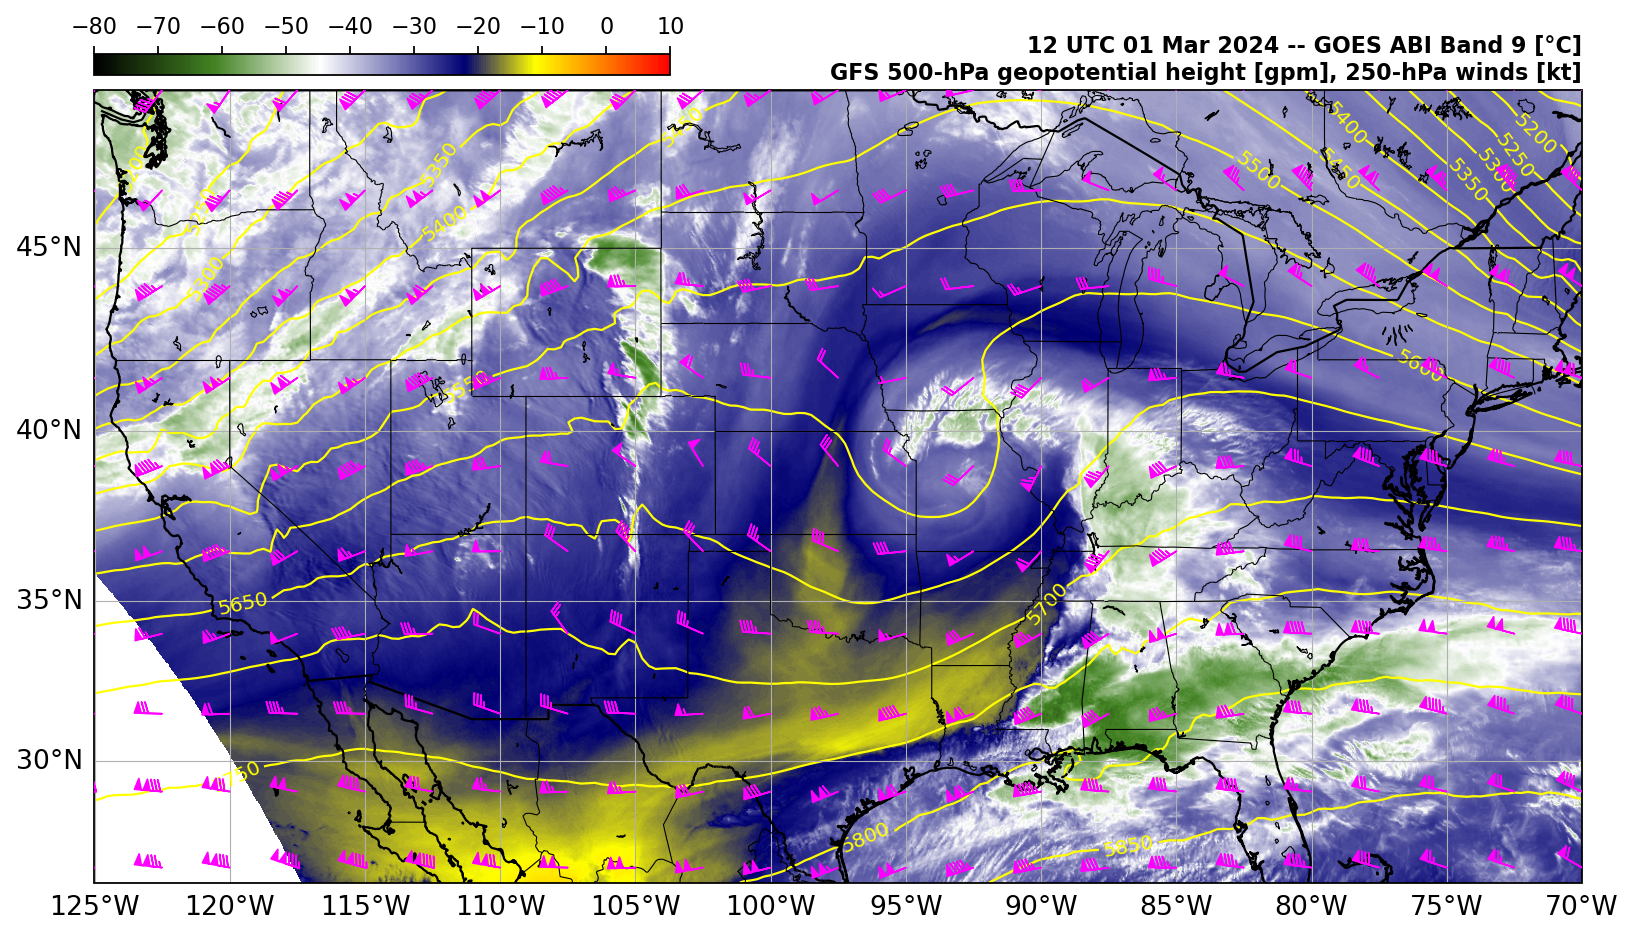

In [9]:
#### Create the plot!
fig = plt.figure(figsize=(12,9), dpi=160)
ax = fig.add_subplot(1, 1, 1, projection=merc)
ax.set_extent([minlon-0.01, maxlon+0.01, minlat-0.01, maxlat+0.01], crs=pc)
im = ax.imshow(abi, cmap=colormap, vmin=v0, vmax=v1, origin='upper', extent=(xx.min(),xx.max(),yy.min(),yy.max()),
               transform=geos, interpolation='bilinear')
ax.barbs(lon[::10], lat[::10], u[wind_level].values[::10,::10]*1.943844, v[wind_level].values[::10,::10]*1.943844, pivot='tip', 
         zorder=50, color='magenta', length=5, linewidth=0.75, transform=pc, sizes={'emptybarb': 0})
cl = ax.contour(lon2d, lat2d, ght[geoheight_level].values, np.arange(0,10001,50), colors='yellow', linewidths=1., transform=pc, 
                transform_first=True)
ax.clabel(cl, cl.levels, inline=True, fmt='%d', fontsize=9)
ax.add_feature(coastline, linewidth=1., edgecolor=geog_color, zorder=10)
ax.add_feature(borders, linewidth=1., edgecolor=geog_color, zorder=10)
ax.add_feature(states, linewidth=0.5, edgecolor=geog_color, zorder=10)
ax.add_feature(lakes, linewidth=0.5, edgecolor=geog_color, facecolor='none', zorder=10)
addgridlines(ax)
if channel >= 7:
    addcolorbar(fig, ax, im, tick_levels, '')  # empty string to hide colorbar title
title_tuple = (dt.strftime('%H UTC %d %b %Y'), channel, geoheight_level, wind_level)
title = '%s -- GOES ABI Band %d [\N{DEGREE SIGN}C]\nGFS %d-hPa geopotential height [gpm], %d-hPa winds [kt]' % title_tuple
ax.text(maxlon, maxlat+0.15, title, ha='right', va='bottom', transform=pc, weight='bold', size=10)
#### Save the image as a PNG file
plt.savefig(PNGname, dpi=120, bbox_inches='tight', pad_inches=0.05)  # comment this line to avoid saving image
plt.show()
#plt.close()